In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import lib
import plotting

In [4]:
from multiprocessing import Pool
import pickle
from collections import defaultdict

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA

In [6]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [7]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [13]:
results_prefix = "[WIKIDATA_PAPER]"

sequence_file = os.path.join(cfg.get("directory", "exchange"), results_prefix + "001_clustering.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels.p")

In [14]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,2,1,2,0,4,6,2,2
1,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...","[Create Item, Break, Add Sitelink, Break, Merg...",1000036,JShenk,"[0.02643738030717696, 0.02643738030717696, 0.0...",1,0,2,4,3,3,1,1,1
2,False,False,7,4,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",1000078,Egor-belikov,"[0.025412586144359806, 0.025412586144359806, 0...",1,1,0,3,1,2,4,4,4
3,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...","[Create Item, Break, Remove Sitelink, Add Site...",100008,Wars,"[0.027056268692473535, 0.02705626869247354, 0....",1,1,0,3,1,2,4,1,1
4,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.025862068965517248, 0.025862068965517244, 0...",1,1,0,3,1,2,4,4,4


In [15]:
len(df)

88148

In [16]:
break_label = cfg.get("preprocessing", "break_label")
break_label

'BREAK'

In [17]:
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,2,1,2,0,4,6,2,2
1,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_ADD, BREAK, ME...","[Create Item, Break, Add Sitelink, Break, Merg...",1000036,JShenk,"[0.02643738030717696, 0.02643738030717696, 0.0...",1,0,2,4,3,3,1,1,1
2,False,False,7,4,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",1000078,Egor-belikov,"[0.025412586144359806, 0.025412586144359806, 0...",1,1,0,3,1,2,4,4,4
3,False,False,9,6,"[ENTITY_CREATE, BREAK, SITELINK_REMOVE, SITELI...","[Create Item, Break, Remove Sitelink, Add Site...",100008,Wars,"[0.027056268692473535, 0.02705626869247354, 0....",1,1,0,3,1,2,4,1,1
4,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.025862068965517248, 0.025862068965517244, 0...",1,1,0,3,1,2,4,4,4


In [18]:
print(len(df), df['length'].sum())
#df = df.loc[~df['is_bot']].reset_index(drop=True)
print(len(df), df['length'].sum())

88148 76605794
88148 76605794


In [19]:
length_full = df.sort_values("length", ascending=False)['length'].values
length_nobreak = df.sort_values("length_nobreak", ascending=False)['length_nobreak'].values

In [20]:
from matplotlib import pyplot as plt

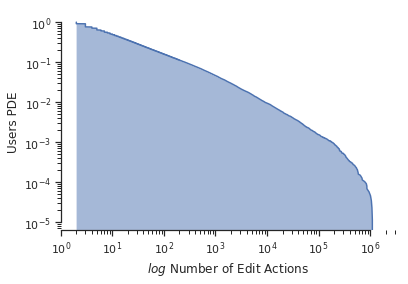

In [21]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots()
ax.loglog(length_full, np.linspace(0,1,len(length_full)))
ax.fill_between(length_full, np.linspace(0,1,len(length_full)), alpha=0.5)
ax.set_xlim(left=1)
#ax.set_ylim(0,1)
#ax.plot(length_nobreak)
#ax.set_xscale("log")
#ax.set_yscale("log", nonposy='clip')
ax.set_ylabel("Users PDE")
ax.set_xlabel("$log$ Number of Edit Actions")
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sns.despine(fig, trim=True)

In [22]:
fig.tight_layout()
store_path = os.path.join(cfg.get("directory", "results"), results_prefix + "dataset_pde")
fig.savefig(store_path + ".png", transparent=True, bbox_inches="tight")
fig.savefig(store_path + ".pdf", transparent=True, bbox_inches="tight")